# Import the libraries that are needed

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

TensorFlow version: 2.9.2


# Initialize train and test dataset

In [10]:
targetdata = np.loadtxt('verschilgeschaald.csv',dtype=float,delimiter=',') #data that we want to predict
dim_targetdata = 99 #number of values that need to be predicted per input point
modinfo = np.loadtxt('modinfo.csv',dtype=float,delimiter=',') #input data for the model
dim_modinfo = 4 #number of input parameters per input point
train_size = 6300 #number of datapoints in the train dataset
test_size = 1000 #number of datapoints in the test dataset
dim_latent_space = 5 #dimension of the latent space representation

In [4]:
indexen = range(len(targetdata))

#X_trainges, X_testges, training_yges, y_testges = train_test_split(modinfo, verschilgeschaald, train_size=2500, test_size=2400, random_state=333)
verschilgeschaald_train, verschilgeschaald_test, indexen_trainges, indexen_testges = train_test_split(targetdata, indexen, train_size=train_size, test_size=test_size, random_state=333)


#Creating the encoder-decoder

In [6]:
X = np.array(verschilgeschaald_train).reshape(len(verschilgeschaald_train), dim_targetdata)

params_input = keras.Input(shape=(dim_targetdata)) #creating the input layer
encoder = tf.keras.layers.Dense(dim_latent_space)(params_input) 
decoder = tf.keras.layers.Dense(dim_targetdata)(encoder)

model = keras.Model(inputs=params_input,outputs=decoder)
model.compile(optimizer='adam', loss='mse')
model.summary()
hist = model.fit(X,X,epochs=1000,validation_split=0.2,batch_size=32)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 99)]              0         
                                                                 
 dense (Dense)               (None, 5)                 500       
                                                                 
 dense_1 (Dense)             (None, 99)                594       
                                                                 
Total params: 1,094
Trainable params: 1,094
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
158/158 [==============================] - 1s 3ms/step - loss: 7.1105 - val_loss: 0.0410
Epoch 2/1000
158/158 [==============================] - 0s 3ms/step - loss: 6.7822 - val_loss: 0.0409
Epoch 3/1000
158/158 [==============================] - 0s 3ms/step - loss: 6.4811 - val_loss: 0.0412
Epoch 4/1000
158/

# Extract the hidden states

In [7]:
Xen = np.array(targetdata).reshape(len(targetdata), 99)
layer_output=model.get_layer('dense').output #'dense' is the name of the encoder layer, if the algorithm is performed multiple times, the name changes to dense_number
intermediate_model=tf.keras.models.Model(inputs=params_input,outputs=layer_output)
tussen=intermediate_model.predict(Xen) # = hidden vectors
np.savetxt("hidden.csv", tussen, delimiter=",")

230/230 [==============================] - 0s 1ms/step


# Make decoder model

In [8]:
layer_hidden = model.get_layer('dense').output #'dense' is the name of the encoder layer, if the algorithm is performed multiple times, the name changes to dense_number
decoder_model = tf.keras.models.Model(inputs=layer_hidden,outputs=decoder)

# Train the neural network to predict the hidden states

In [11]:
#3 layers with 100, 20 and dim_latent_space neurons, as dim_latent_space changes the number of neurons in the layers might need to be changed to obtain an optimal model
modinfo_train = modinfo[indexen_trainges]
tussen_train = tussen[indexen_trainges]
X= np.array(modinfo_train).reshape(len(modinfo_train), dim_modinfo)
Y = np.array(tussen_train).reshape(len(tussen_train), dim_latent_space)

params_input = keras.Input(shape=(dim_modinfo))
lay1 = tf.keras.layers.Dense(100)(params_input)
lay2 = tf.keras.layers.Dense(20)(lay1)
lay3 = tf.keras.layers.Dense(dim_latent_space)(lay2)

modelnn = keras.Model(inputs=params_input,outputs=lay3)
modelnn.compile(optimizer='adam', loss='mse')
modelnn.summary()
hist = modelnn.fit(X,Y,epochs=1000,validation_split=0.2,batch_size=32)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 100)               500       
                                                                 
 dense_3 (Dense)             (None, 20)                2020      
                                                                 
 dense_4 (Dense)             (None, 5)                 105       
                                                                 
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
158/158 [==============================] - 1s 3ms/step - loss: 49.1446 - val_loss: 9.5388
Epoch 2/1000
158/158 [==============================] - 0s 3ms/step - loss: 44.4395 - 

# Use the decoder to go back to the full representation 

In [12]:
Xtot = np.array(modinfo).reshape(len(modinfo), dim_modinfo)
ouputnn = np.array(modelnn.predict(Xtot))
ouputnnsh = np.array(ouputnn).reshape(len(ouputnn),dim_latent_space)
predictie = decoder_model.predict(ouputnnsh)

230/230 [==============================] - 0s 2ms/step


Text(0.5, 0, 'Time')

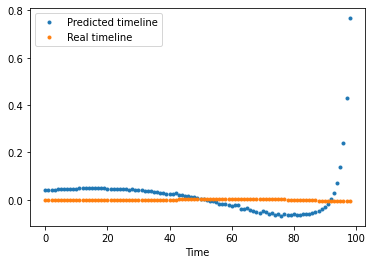

In [17]:
plt.plot(predictie[5],'.',label='Predicted timeline')
plt.plot(targetdata[5],'.',label='Real timeline')
plt.legend()
plt.xlabel('Time')

Text(0.5, 0, 'Depth')

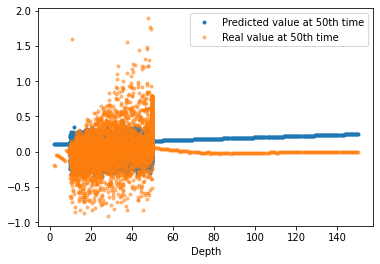

In [21]:
plt.plot(modinfo[:,0],predictie[:,50],'.',label='Predicted value at 50th time')
plt.plot(modinfo[:,0],targetdata[:,50],'.',alpha=0.5,label='Real value at 50th time')
plt.legend()
plt.xlabel('Depth')